# Projeto de Data Engineering Simples
Nesse projeto iremos fazer o Data Engineering basico, onde pegamos os dados da pagina de livros http://books.toscrape.com/ (essa pagina foi feita para fazer e praticar o web scraping). Para coletarmos os dados vamos utilizar o pacote BeautifulSOup e para clicar/trocar de paginas usamos o Selenium.

Nesse site de livros, inicialmente eu coletei todas as urls de todos os mil livros, com essas Url's fiz a coleta do nome do livro, o preço que o livro está custando, a avaliação feita do livro em formato de estrelas (de 1-5), o tipo/gênero do livro e por fim se o livro estava no estoque. Além disso criei uma tabela dentro de um banco de dados para alimentar em cada iteração (nesse caso estou utilizando SQL Server) e por fim temos nosso Data frame que tambem exportamos para csv.

Só para mostrar o conjunto final dos dados, eu fiz alguns plots e analises breves para mostrar como ficaram esses valores.


## Coletando os Dados

In [ ]:
#Bibliotecas importantes

from selenium import webdriver
from selenium.webdriver.firefox.firefox_binary import FirefoxBinar
#Bibliotecas para fazer web scrapy dos sites
import requests
from requests import get
from bs4 import BeautifulSoup

#trabalhar com data frame
import pandas as pd

#Biblioteca para o processamento de linguagem
import re
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.util import bigrams

In [1]:
#Utilizando o FireFox para automatizar a passagem de paginas com o Selenium
binary = FirefoxBinary('C:\\Program Files\\Mozilla Firefox\\firefox.exe')

driver = webdriver.Firefox(firefox_binary=binary, executable_path=r'C:\\geckodriver.exe')

In [4]:
#Iremos encontrando dentro do HTML da pagina todas as URL's que levam para as paginas dos livros em si, 
#utilizando BeautifulSoup

driver.get('http://books.toscrape.com/')

sites = []
soup = BeautifulSoup(driver.page_source)

categories = soup.find_all('div', class_="side_categories")
todas_cat = []
aux_cat = categories[0].find_all('li')
for i in range(1,len(aux_cat)):
    todas_cat.append(aux_cat[i].text.replace('\n','').replace(' ',''))


aux_numbepages = soup.find_all('ul', class_='pager')
aux_numbepages2 = aux_numbepages[0].find_all('li', class_ = 'current')

aux_numbepages3 = aux_numbepages2[0].text.replace('\n','').replace(' ','').replace('Page','').replace('of','')

total_pages = int(aux_numbepages3[1:])
page = int(aux_numbepages3[:-2])

#Um loop para percorrer o numero total de paginas (total_pages), pois cada pagina disponibiliza 20 livros.
for i in range(page,total_pages):
    div_sit = soup.find_all('div', class_='image_container')
    for i in range(0,len(div_sit)):
        aux = div_sit[i].find('a',href = True)
        sit_name = aux['href'].replace('catalogue','')
        sites.append('http://books.toscrape.com/catalogue/' + sit_name)
    
    submit_button  = driver.find_element_by_xpath('//li[@class="next"]//a')
    submit_button.click()
    soup = BeautifulSoup(driver.page_source)

div_sit = soup.find_all('div', class_='image_container')

#Esse loop final é para pegar a ultima pagina do nosso site.
for i in range(0,len(div_sit)):
    aux = div_sit[i].find('a',href = True)
    sit_name = aux['href'].replace('catalogue','')
    #print(sit_name)
    sites.append('http://books.toscrape.com/catalogue/' + sit_name)

In [37]:
#Função para troca o numero escrito para o numerico em si
def chang_est(word):
    if(word[:7] == 'Instock'):
        return('Sim')
    else:
        return('Nao')

Conectando e criando uma tabela no SQL Server 2014

In [56]:
#Mostrando a criação da tabela dentro odo banco de dados
import pyodbc 
# Some other example server values are
# server = 'localhost\sqlexpress' # for a named instance
# server = 'myserver,port' # to specify an alternate port
server = 'DESKTOP-D2A5BFQ\SQLEXPRESS' 
database = 'projeto' 
username =  ''
password = '' 
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

cursor.execute('''
                CREATE TABLE LIVROS
                (
                IDLIVRO INT PRIMARY KEY IDENTITY,
                NOME VARCHAR(300),
                PRECO MONEY,
                ESTOQUE CHAR(3),
                ESTILO VARCHAR(30),
                AVALIACAO INT
                )

''')
cursor.commit()

Coletando os dados desejado dentro de cada URL encontrada anteriormente, inserindo dentro de arrays vazios. Por fim alimentamos nos banco de dados.

In [59]:
titulo = []
preco = []
estoque = []
estilo = []
avaliacao = []
num2words = {'One':1,'Two' : 2,'Three': 3, 'Four':4,'Five':5}

for j in range(0,len(sites)):
    results = requests.get(sites[j])
    soup2 = BeautifulSoup(results.text, "html.parser")

    div_carct = soup2.find_all('div',  class_='col-sm-6 product_main')

    p_carct = div_carct[0].find_all('p')

    tit = div_carct[0].find_all('h1')[0].text
    pre = float(p_carct[0].text[2:])
    stoq = chang_est(p_carct[1].text.replace('\n','').replace(' ',''))
    estre = num2words[p_carct[2]['class'][1]]
    
    ul_est = soup2.find_all('ul', class_='breadcrumb')
    
    for litag in ul_est[0].find_all('li'):
        if litag.text.replace('\n','').replace(' ','') in todas_cat:
            stilo = litag.text.replace('\n','')

    titulo.append(tit)
    preco.append(pre)
    estoque.append(stoq)
    avaliacao.append(estre)
    estilo.append(stilo)

#Aqui inserimos nosso dados dentro de um banco de dados
    #values = (tit,pre,stoq,tex,estre)
    #insert_query = '''INSERT INTO LIVROS (NOME,PRECO,ESTOQUE,ESTILO,AVALIACAO)
    #              VALUES (?,?,?,?,?)'''
    #cursor.execute(insert_query,values)
    #cursor.commit()

Mostrando como ficou no final nosso banco de dados

In [144]:
cursor.execute('SELECT TOP(100) * FROM LIVROS  ')

for row in cursor:
    print(row)

(1, 'A Light in the Attic', Decimal('51.7700'), 'Sim', 'Food and Drink', 3)
(2, 'Tipping the Velvet', Decimal('53.7400'), 'Sim', 'Food and Drink', 1)
(3, 'Soumission', Decimal('50.1000'), 'Sim', 'Food and Drink', 1)
(4, 'Sharp Objects', Decimal('47.8200'), 'Sim', 'Food and Drink', 4)
(5, 'Sapiens: A Brief History of Humankind', Decimal('54.2300'), 'Sim', 'Food and Drink', 5)
(6, 'The Requiem Red', Decimal('22.6500'), 'Sim', 'Food and Drink', 1)
(7, 'The Dirty Little Secrets of Getting Your Dream Job', Decimal('33.3400'), 'Sim', 'Food and Drink', 4)
(8, 'The Coming Woman: A Novel Based on the Life of the Infamous Feminist, Victoria Woodhull', Decimal('17.9300'), 'Sim', 'Food and Drink', 3)
(9, 'The Boys in the Boat: Nine Americans and Their Epic Quest for Gold at the 1936 Berlin Olympics', Decimal('22.6000'), 'Sim', 'Food and Drink', 4)
(10, 'The Black Maria', Decimal('52.1500'), 'Sim', 'Food and Drink', 1)
(11, 'Starving Hearts (Triangular Trade Trilogy, #1)', Decimal('13.9900'), 'Sim'

Por fim criamos o data frame e exportamos para CSV.

In [66]:
import pandas

dict_df = {'Nome_Filme' : titulo,
           'Preco' : preco,
           'Tem_estoque' : estoque,
           'Avaliacao' : avaliacao,
           'Estilo' : estilo}

Df_final = pd.DataFrame(dict_df) 

Df_final.to_csv()

In [67]:
Df_final.head()

,Nome_Filme,Preco,Tem_estoque,Avaliacao,Estilo
0,A Light in the Attic,51.77,Sim,3,Poetry
1,Tipping the Velvet,53.74,Sim,1,Historical Fiction
2,Soumission,50.10,Sim,1,Fiction
3,Sharp Objects,47.82,Sim,4,Mystery
4,Sapiens: A Brief History of Humankind,54.23,Sim,5,History


## Visualização dos Dados

Vamos fazer uma breve visualização dos dados, para ter uma noção de como esses dados estão dispostos.

Podemos agrupar em tipos de estilos para ver a media do preço por estilo e das avaliações. Além disso podemos agrupar por avaliação paara esta conectado de alguma forma.

In [72]:
Group_estilo = Df_final.groupby('Estilo')

In [77]:
Group_estilo2 = Group_estilo.mean()
Group_estilo2['Count'] = Group_estilo.count()['Preco']

In [79]:
Group_estilo2.head(10)

,Preco,Avaliacao,Count
Estilo,,,
Academic,13.120000,2.000000,1
Add a comment,35.796418,2.761194,67
Adult Fiction,15.360000,5.000000,1
Art,38.520000,3.625000,8
Autobiography,37.053333,3.000000,9
Biography,33.662000,2.200000,5
Business,32.460000,2.916667,12
Childrens,32.638276,2.620690,29
Christian,42.496667,2.666667,3


Podemos observar pelos graficos que os estilos de suspense, novels e politics são com preços elevados, porém a maioria dos estilos tem uma quantidade superior a 30 reais, sendo os mais baratos custando apenas 10 reais. Com maiores avaliações são o Adult Fiction, Erotica e Novels, porém quando vemos a quantidade desses livros temos que tem apenas um exemplar. Os livros com as piores avaliaçoes são do tipo crime,cultural, paranormal e short stories que tambem tem apenas um exemplar.

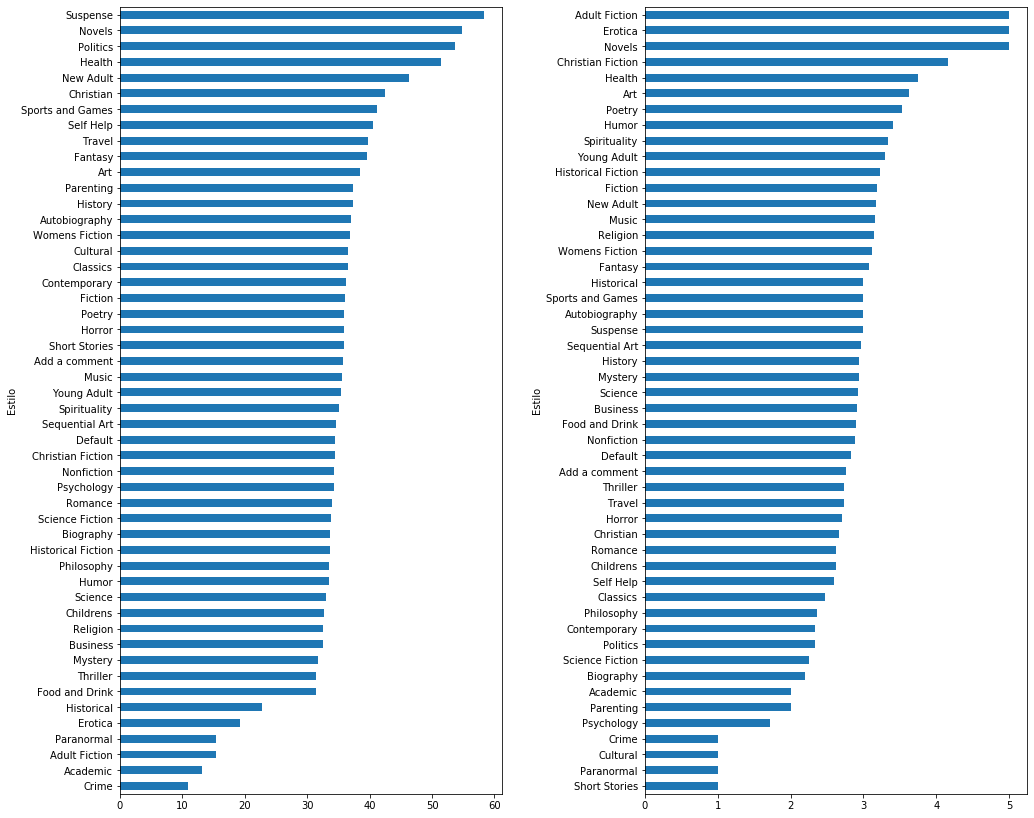

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

fig,axis = plt.subplots(1,2,figsize = (15,12))

Group_estilo2['Preco'].sort_values().plot.barh(ax = axis[0]);
Group_estilo2['Avaliacao'].sort_values().plot.barh(ax = axis[1]);

plt.tight_layout(pad = 3)

Majoritariamente o estilo de livros é Default, que deve ser uma opção quando não se sabe ou não foi definido o estilo do livro. Podemos ver o proximo que mostra que nonfiction tambem com uma grande quantidade de livros, assim como sequential art.

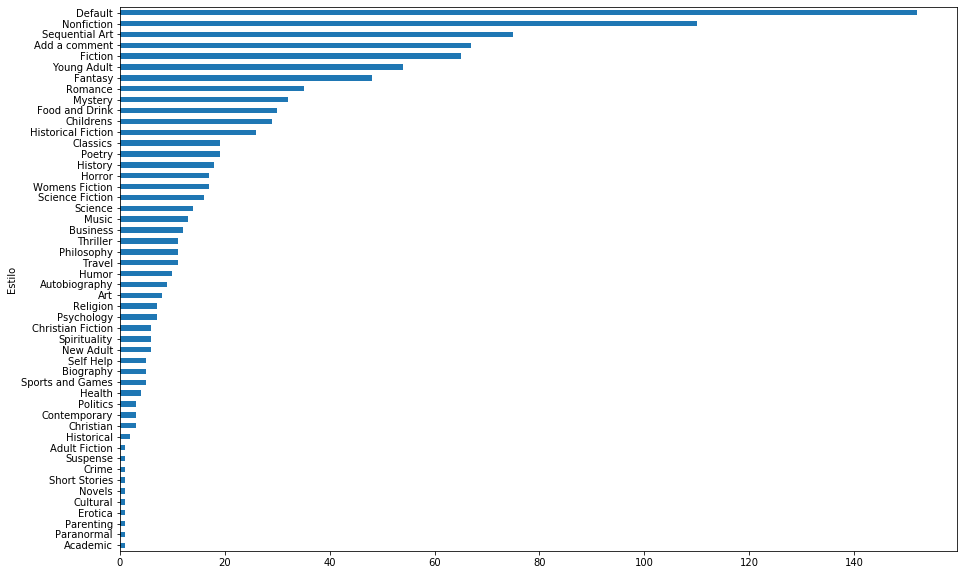

In [118]:
Group_estilo2['Count'].sort_values().plot.barh(figsize = (15,10));

Vemos que todos os livros tem no estoque.

In [121]:
Df_final['Tem_estoque'].value_counts()

Sim    1000
Name: Tem_estoque, dtype: int64

Agrupando nossos dados por avaliação

Podemos ver que a avaliação não influencia no preço dos livros, todos estão proximos. Vemos que os livros com avaliação baixa é que tem em maior quantidade, porém as demais avaliações ficam proximas.

In [123]:
Group_aval = Df_final.groupby('Avaliacao')

Group_aval2 = Group_aval.mean()
Group_aval2['Count'] = Group_aval.count()['Preco']

In [125]:
Group_aval2.head(10)

,Preco,Count
Avaliacao,,
1,34.561195,226
2,34.810918,196
3,34.692020,203
4,36.093296,179
5,35.374490,196


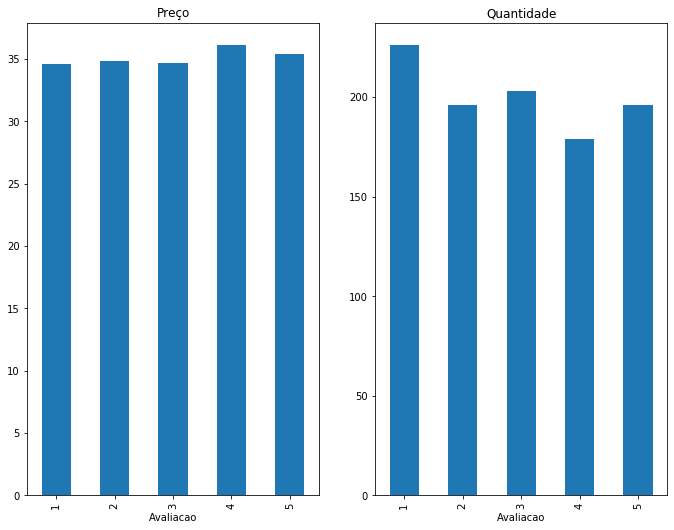

In [136]:
fig,axis = plt.subplots(1,2,figsize = (10,8))

Group_aval2['Preco'].plot(kind = 'bar',ax = axis[0]);
Group_aval2['Count'].plot(kind = 'bar',ax = axis[1]);

axis[0].set_title('Preço')
axis[1].set_title('Quantidade')

plt.tight_layout(pad = 3)

# Conclusão

Esse projeto teve o intuito de mostrar ferramentas para fazer um web scrapy de paginas de internet para conseguir dados, dessa forma foi utilizado BeautifulSoup para pegar os dados e Selenium para passagem de pagina. Ao mesmo tempo que iamos colentando os dados, foi criado uma tabela dentro de um banco de dados para fazer a transferencia dos dados e por fim tambem exportamos para um csv.

No final foi feito uma breve analise dos dados, porém nada muito profundo, só para ver o estado final dos dados.